# Import necessary packages

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline


# Import data

In [2]:
data = pd.read_csv('Licensed_Child_Care_Providers_and_Facilities.csv', parse_dates=['Closing Time', 'Opening Time'])
data.head()

,License Number,County,Name,Name Reversed,Type of Child Care,Enforcement Action,Intent to Revoke,Street Address,City,State,...,Age Range,Age Group,Capacity,Opening Time,Closing Time,Special Conditions,Government Programs,Delaware STARS Level,Geocoded Location,Count
0,27390,Sussex,LISA STOECKEL,"STOECKEL, LISA",Licensed Family Child Care,NaN,NaN,22448 PETERKINS ROAD,GEORGETOWN,DE,...,6 months through 5 years.,Infant through Pre-School,9,2021-06-13 07:30:00,2021-06-13 17:00:00,NaN,Child Care Food Program,0,POINT (-75.325081 38.66056076),1
1,27399,New Castle,YMCA OF DELAWARE / CENTRAL BRANCH YMCA CHILDRE...,YMCA OF DELAWARE / CENTRAL BRANCH YMCA CHILDRE...,Licensed Child Care Center,NaN,NaN,501 WEST 11TH STREET,WILMINGTON,DE,...,6 weeks through 5 years.,Infant through Pre-School,99,2021-06-13 06:45:00,2021-06-13 18:00:00,NaN,Child Care Food Program;Nonprofit;Purchase of ...,5,POINT (-75.5514135 39.748761),1
2,27407,Kent,DOVER EDUCATIONAL & COMMUNITY CENTER,DOVER EDUCATIONAL & COMMUNITY CENTER,Licensed Child Care Center,Warning of Probation,Intent to Place on Warning of Probation,744 RIVER ROAD,DOVER,DE,...,1 year through 12 years.,Toddler through School-Age,59,2021-06-13 06:00:00,2021-06-13 20:00:00,NaN,Purchase of Care,0,POINT (-75.5158545 39.152538),1
3,27410,New Castle,ELIZABETH JOHNSON,"JOHNSON, ELIZABETH",Licensed Family Child Care,NaN,NaN,2011 WEST STREET,WILMINGTON,DE,...,6 weeks through 12 years.,Infant through School-Age,9,2021-06-13 07:00:00,2021-06-13 17:00:00,NaN,Child Care Food Program;Purchase of Care,0,POINT (-75.5426475 39.754116),1
4,27411,New Castle,JANEL DEMONIA,"DEMONIA, JANEL",Licensed Family Child Care,NaN,NaN,1113 CADE STREET,WILMINGTON,DE,...,6 weeks through 12 years.,Infant through School-Age,9,2021-06-13 15:00:00,2021-06-13 23:00:00,NaN,Private,0,POINT (-75.533895 39.742884),1


# Data Preprocessing


### Check missing values of each variable

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   License Number        1004 non-null   int64         
 1   County                1004 non-null   object        
 2   Name                  1004 non-null   object        
 3   Name Reversed         1004 non-null   object        
 4   Type of Child Care    1004 non-null   object        
 5   Enforcement Action    10 non-null     object        
 6   Intent to Revoke      24 non-null     object        
 7   Street Address        1004 non-null   object        
 8   City                  1004 non-null   object        
 9   State                 1004 non-null   object        
 10  Zip Code              1004 non-null   int64         
 11  Phone Number          1004 non-null   object        
 12  Age Range             1004 non-null   object        
 13  Age Group         

*We can see 'Enforcement Action', 'Intent to Revoke', and 'Special Conditions' have too many missing values.*

### Add a variable to calculate the service duration (in hours) of each facility

In [4]:
# Get the time difference between purchase time and signup time
time_diff = data['Closing Time'] - data['Opening Time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['service time'] = time_diff/3600



### Convert 'Government Programs' to a binary variable

In [5]:
data.loc[pd.isnull(data['Government Programs']),['InGovProgram']]=0
data.loc[~pd.isnull(data['Government Programs']),['InGovProgram']]=1

In [6]:
#check if we have done it correctly
data[['InGovProgram']].value_counts()

InGovProgram
1.0             922
0.0              82
dtype: int64

### Check basic data statistics for contiuous variables

In [7]:
data.iloc[:,[14,22]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Capacity,1004.0,50.494024,63.704115,5.0,9.0,12.0,76.0,585.0
service time,1003.0,11.099036,2.538809,2.5,10.0,11.0,11.5,23.5


*Min, max values for capacity and service time make sense.*

### Check unique values for meaningful variables

In [8]:
subset = data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,18,19,20,21,22,23]]

In [9]:
subset['Government Programs'] = subset['Government Programs'].astype(str) 
subset['Geocoded Location'] = subset['Geocoded Location'].astype(str) 
subset['Enforcement Action'] = subset['Enforcement Action'].astype(str) 
subset['Intent to Revoke'] = subset['Intent to Revoke'].astype(str) 


In [10]:
for column in subset.columns:
    uniques = sorted(subset[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:3])

License Number        1004	 [27390, 27399, 27407]
County                   6	 ['KENT', 'Kent', 'NEW CASTLE']
Name                  1004	 ['4-H @ LAKE FOREST SOUTH', '4-H AFTERSCHOOL @ KIRK MIDDLE SCHOOL', '4-H AFTERSCHOOL @ PHILLIP SHOWELL ELEMENTARY SCHOOL']
Name Reversed         1004	 ['4-H @ LAKE FOREST SOUTH', '4-H AFTERSCHOOL @ KIRK MIDDLE SCHOOL', '4-H AFTERSCHOOL @ PHILLIP SHOWELL ELEMENTARY SCHOOL']
Type of Child Care       3	 ['Licensed Child Care Center', 'Licensed Family Child Care', 'Licensed Large Family Child Care']
Enforcement Action       4	 ['Probation', 'Probation Extension', 'Warning of Probation']
Intent to Revoke         6	 ['Intent to Place on Probation', 'Intent to Place on Probation Extension', 'Intent to Place on Warning of Probation']
Street Address         994	 ['1 BASSETT AVENUE', '1 CORONET COURT', '1 EAST 31ST STREET']
City                    44	 ['BEAR', 'BETHEL', 'BLADES']
State                    1	 ['DE']
Zip Code                52	 [19701, 19702, 1970

*Understanding the variables:*
1. License number is facility id
2. Data was collected from 6 counties
3. As name and name reversed both have 1004 observations, we can tell that all facilities are individual provider.
4. Three types of child care facilities are provided. 
5. For 'Enforcement Action' and 'Intent to Revoke', we may consider drop them.
6. Street address has 1004 observations with 994 unique values which means some facilities share a same building.
7. 44 cities are involved.
8. All observations are from DE.
9. 52 zip code zones are involved.
10. Age range and age group are quite similar while age group is more organized with 10 categories.
11. Capacity can be treated a continous variable as different facilities can have different capacities
12. From opening time & closing time we get the service duration. Closing time has one missing value which can be dropped.
13. Special conditions has too many missing values, we may consider drop it.
14. Government Programs has 20 categories which can be converted to a binary variable representing whether the facility participate a government program or not.
15. Delaware STARS Level has 6 categories ranging from 0 to 5. I have checked online and found that the STARS Level ranges from 1 to 5 which means facilities with 0 have not started with the STARS Level.
16. Geocode location is the geo coordinates for each facility.
17. Count is always 1 which can be dropped.



### Create a subset

In [11]:
#keep facalities with no Enforcement Action, no Intent to Revoke, no Special Conditions
data_s = data[pd.isnull(data['Enforcement Action'])&pd.isnull(data['Intent to Revoke'])&pd.isnull(data['Special Conditions'])]

In [12]:
#drop one observation with missing closing time
data_s.dropna(subset=['service time'], inplace=True)

In [13]:
data_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 1003
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   License Number        952 non-null    int64         
 1   County                952 non-null    object        
 2   Name                  952 non-null    object        
 3   Name Reversed         952 non-null    object        
 4   Type of Child Care    952 non-null    object        
 5   Enforcement Action    0 non-null      object        
 6   Intent to Revoke      0 non-null      object        
 7   Street Address        952 non-null    object        
 8   City                  952 non-null    object        
 9   State                 952 non-null    object        
 10  Zip Code              952 non-null    int64         
 11  Phone Number          952 non-null    object        
 12  Age Range             952 non-null    object        
 13  Age Group          

In [14]:
#create a subset including all necessary variables
df = data_s[['County','Type of Child Care','City','Zip Code','Age Group','Capacity','Opening Time','Closing Time','Delaware STARS Level','service time','InGovProgram']]

In [15]:
#check it and we now have a subset with 952 observations
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 1003
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   County                952 non-null    object        
 1   Type of Child Care    952 non-null    object        
 2   City                  952 non-null    object        
 3   Zip Code              952 non-null    int64         
 4   Age Group             952 non-null    object        
 5   Capacity              952 non-null    int64         
 6   Opening Time          952 non-null    datetime64[ns]
 7   Closing Time          952 non-null    datetime64[ns]
 8   Delaware STARS Level  952 non-null    int64         
 9   service time          952 non-null    float64       
 10  InGovProgram          952 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(4)
memory usage: 89.2+ KB


# Exploratory Data Analysis

*I'd like to choose 'Delaware STARS Level' as the dependent variable and would like to have a quick and dirty analysis on the relationship between features and the target*

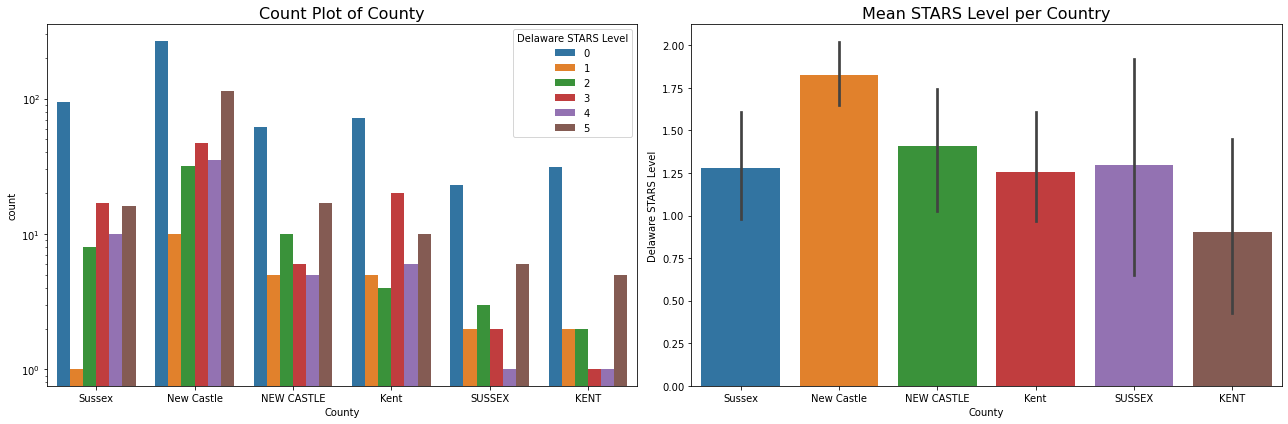

In [16]:
# Visualization of different Counties
grouped = df[['County', 'Delaware STARS Level']].groupby('County').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='County', hue='Delaware STARS Level', data=df, ax=ax[0])
ax[0].set_title('Count Plot of County', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='County', y='Delaware STARS Level', data=df, ax=ax[1]);
ax[1].set_title('Mean STARS Level per Country', fontsize=16)
plt.tight_layout()
plt.show()

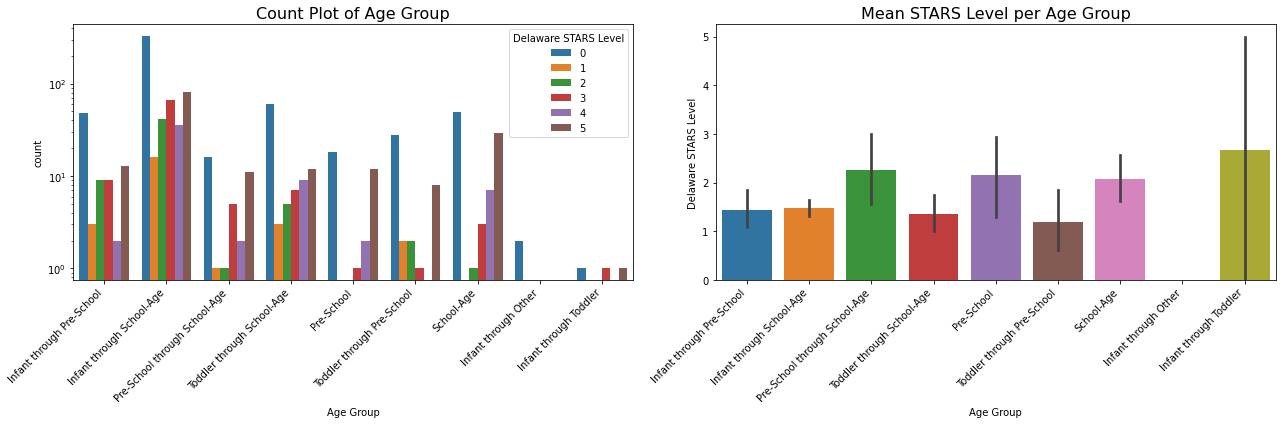

In [17]:
# Visualization of different Age groups
grouped = df[['Age Group', 'Delaware STARS Level']].groupby('Age Group').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='Age Group', hue='Delaware STARS Level', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Age Group', fontsize=16)
ax[0].set_yscale('log')
ax[0].set_xticklabels(['Infant through Pre-School', 'Infant through School-Age', 'Pre-School through School-Age',
       'Toddler through School-Age', 'Pre-School','Toddler through Pre-School','School-Age','Infant through Other','Infant through Toddler'],rotation=45, ha='right', fontsize = 10)
ax[1].set_xticklabels(['Infant through Pre-School', 'Infant through School-Age', 'Pre-School through School-Age',
       'Toddler through School-Age', 'Pre-School','Toddler through Pre-School','School-Age','Infant through Other','Infant through Toddler'],rotation=45, ha='right', fontsize = 10)
ax[0].legend(loc ='upper right',title="Delaware STARS Level")
sns.barplot(x='Age Group', y='Delaware STARS Level', data=df, ax=ax[1]);
ax[1].set_title('Mean STARS Level per Age Group', fontsize=16)
plt.tight_layout()
plt.show()

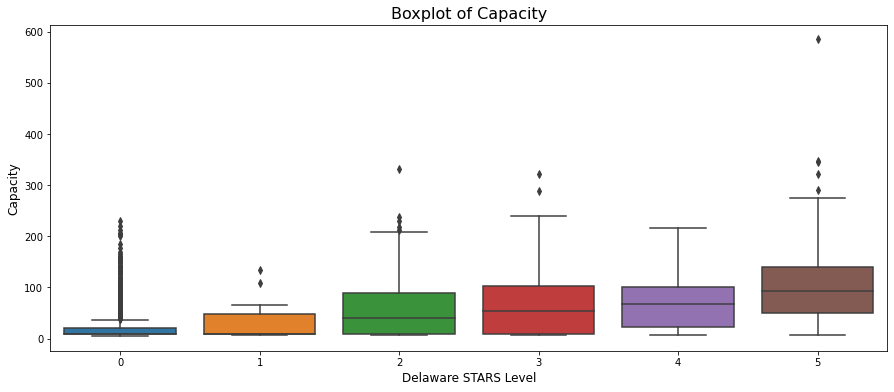

In [18]:
# Visualization of different Capacities
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(df['Delaware STARS Level'],df['Capacity'], ax=ax)
ax.set_title('Boxplot of Capacity', fontsize=16)
ax.set_xlabel('Delaware STARS Level', fontsize=12)
ax.set_ylabel('Capacity', fontsize=12)
plt.show()

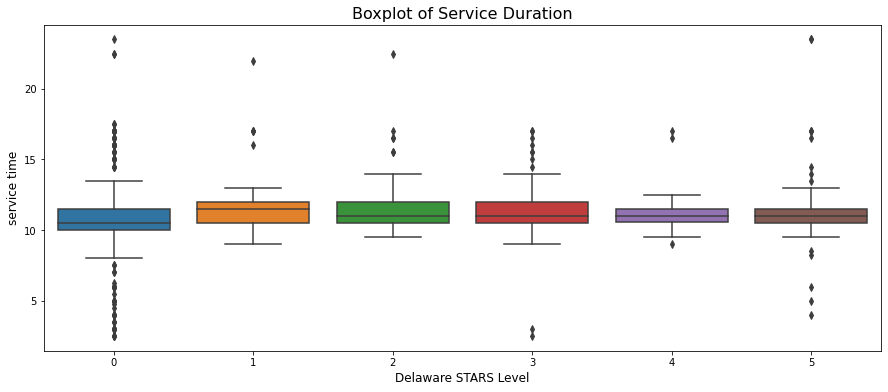

In [19]:
# Visualization of different service durations
fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(df['Delaware STARS Level'],df['service time'], ax=ax)
ax.set_title('Boxplot of Service Duration', fontsize=16)
ax.set_xlabel('Delaware STARS Level', fontsize=12)
ax.set_ylabel('service time', fontsize=12)
plt.show()

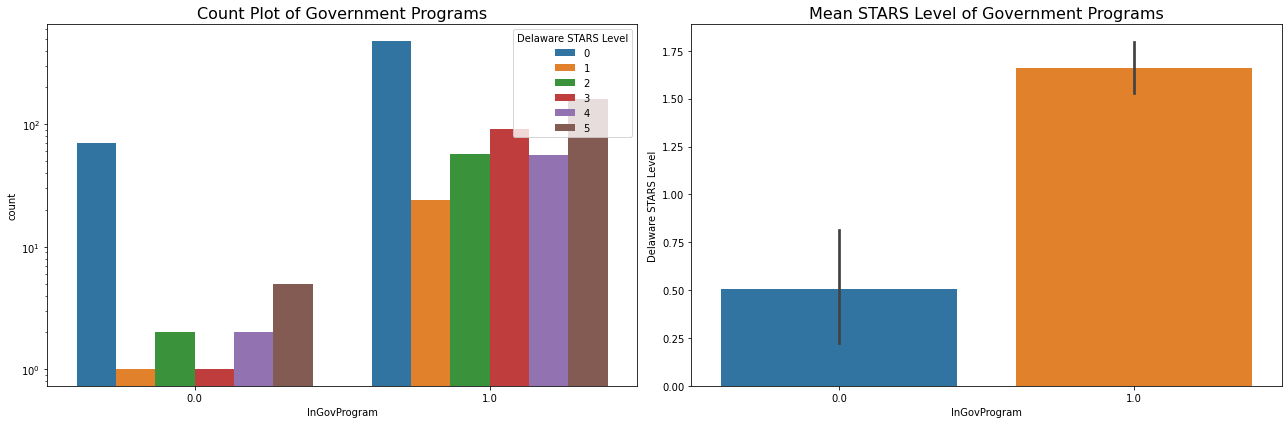

In [20]:
# Visualization of government programs
grouped = df[['InGovProgram', 'Delaware STARS Level']].groupby('InGovProgram').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='InGovProgram', hue='Delaware STARS Level', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Government Programs', fontsize=16)
ax[0].set_yscale('log')
ax[0].legend(loc ='upper right',title="Delaware STARS Level")

sns.barplot(x='InGovProgram', y='Delaware STARS Level', data=df, ax=ax[1]);
ax[1].set_title('Mean STARS Level of Government Programs', fontsize=16)
plt.tight_layout()
plt.show()

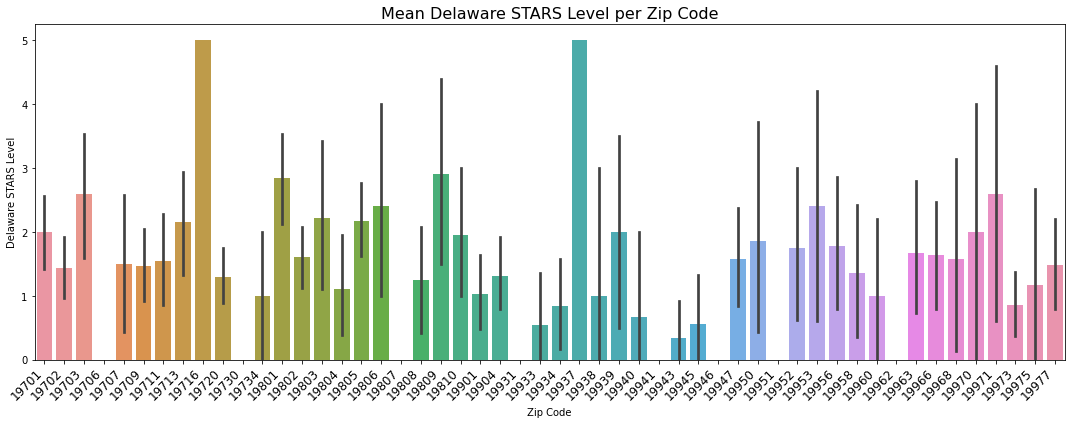

In [21]:
# Visualization of different zip codes
grouped = df[['Zip Code', 'Delaware STARS Level']].groupby('Zip Code').mean().reset_index()
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df['Zip Code'], y=df['Delaware STARS Level'], ax=ax)
ax.set_title('Mean Delaware STARS Level per Zip Code', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.tight_layout()
plt.show()

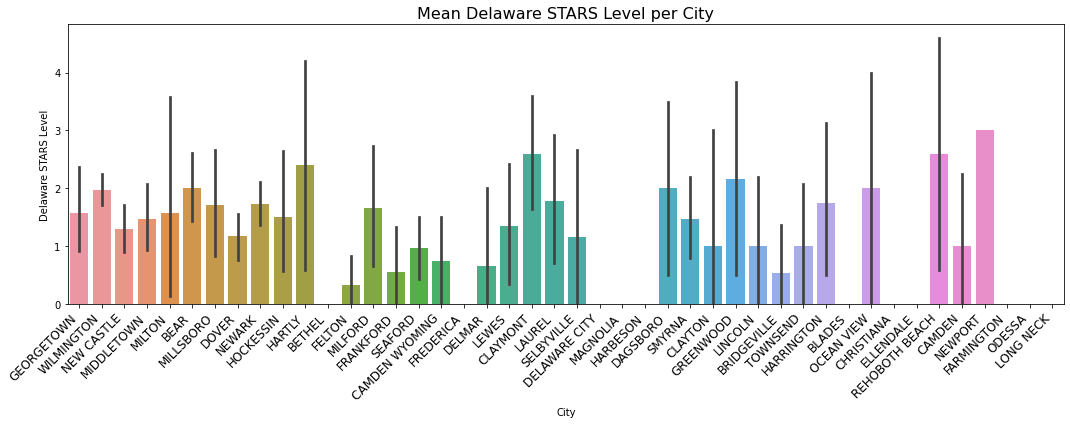

In [22]:
# Visualization of different cities
grouped = df[['City', 'Delaware STARS Level']].groupby('City').mean().reset_index()
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df['City'], y=df['Delaware STARS Level'], ax=ax)
ax.set_title('Mean Delaware STARS Level per City', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.tight_layout()
plt.show()

# Classification Model

In [23]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "14.0.1" 2020-04-14; Java(TM) SE Runtime Environment (build 14.0.1+7); Java HotSpot(TM) 64-Bit Server VM (build 14.0.1+7, mixed mode, sharing)
  Starting server from /Users/dandan/miniconda3/envs/pythonforgnn/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/g1/2frf8xnx2779stl5zvgfrc540000gn/T/tmp563q4dqe
  JVM stdout: /var/folders/g1/2frf8xnx2779stl5zvgfrc540000gn/T/tmp563q4dqe/h2o_dandan_started_from_python.out
  JVM stderr: /var/folders/g1/2frf8xnx2779stl5zvgfrc540000gn/T/tmp563q4dqe/h2o_dandan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_dandan_wwxqvt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [24]:
# Transform df to H2O Frame
h2o_df = H2OFrame(df)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [25]:
h2o_df['Zip Code'] = h2o_df['Zip Code'].asfactor()
h2o_df['Delaware STARS Level'] = h2o_df['Delaware STARS Level'].asfactor()
h2o_df['InGovProgram'] = h2o_df['InGovProgram'].asfactor()


In [26]:
h2o_df.summary()

,County,Type of Child Care,City,Zip Code,Age Group,Capacity,Opening Time,Closing Time,Delaware STARS Level,service time,InGovProgram
type,enum,enum,enum,enum,enum,int,time,time,enum,real,enum
mins,,,,,,5.0,1623558600000.0,1623542400000.0,,2.5,
mean,,,,,,51.38760504201686,1623567563760.5022,1623606153466.387,,11.047093837535034,
maxs,,,,,,585.0,1623607200000.0,1623627000000.0,,23.5,
sigma,,,,,,64.18222917843241,4893017.379120079,8840531.87001737,,2.5455712771987526,
zeros,,,,,,0,0,0,,0,
missing,0,0,0,0,0,0,0,0,0,0,0
0,Sussex,Licensed Family Child Care,GEORGETOWN,19947,Infant through Pre-School,9.0,2021-06-13 07:30:00,2021-06-13 17:00:00,0,9.5,1
1,New Castle,Licensed Child Care Center,WILMINGTON,19801,Infant through Pre-School,99.0,2021-06-13 06:45:00,2021-06-13 18:00:00,5,11.25,1
2,New Castle,Licensed Family Child Care,WILMINGTON,19802,Infant through School-Age,9.0,2021-06-13 07:00:00,2021-06-13 17:00:00,0,10.0,1


In [27]:
# Split into training, valid, and test dataset
train, valid, test = h2o_df.split_frame([0.6, 0.2], seed=42)

feature = ['County', 'Type of Child Care', 'City', 'Zip Code', 'Age Group','Capacity','service time','InGovProgram']
target = 'Delaware STARS Level'

In [28]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [29]:
#Check model summary
model

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1623622614850_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,600.0,725445.0,6.0,20.0,14.45,17.0,145.0,76.34




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.1565895457606704
RMSE: 0.3957139696304269
LogLoss: 0.46921911482052026
Mean Per-Class Error: 0.2192303767261623
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,301.0,0.0,3.0,5.0,3.0,15.0,0.079511,26 / 327
1,138.0,187.0,0.0,0.0,0.0,0.0,0.424615,138 / 325
2,72.0,0.0,241.0,12.0,0.0,3.0,0.265244,87 / 328
3,66.0,0.0,11.0,249.0,0.0,0.0,0.236196,77 / 326
4,64.0,0.0,0.0,0.0,253.0,9.0,0.223926,73 / 326
5,22.0,0.0,3.0,0.0,3.0,298.0,0.085890,28 / 326
6,663.0,187.0,258.0,266.0,259.0,325.0,0.219101,"429 / 1,958"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.780899
1,2,0.985189
2,3,0.998979
3,4,0.998979
4,5,1.000000
5,6,1.000000



ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.3419710893276582
RMSE: 0.5847829420628291
LogLoss: 2.5975246219749644
Mean Per-Class Error: 0.7960166048401343
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,89.0,0.0,1.0,3.0,2.0,7.0,0.127451,13 / 102
1,4.0,0.0,0.0,0.0,0.0,2.0,1.000000,6 / 6
2,4.0,0.0,0.0,1.0,0.0,2.0,1.000000,7 / 7
3,9.0,0.0,0.0,0.0,0.0,3.0,1.000000,12 / 12
4,6.0,0.0,0.0,1.0,0.0,2.0,1.000000,9 / 9
5,21.0,0.0,0.0,2.0,1.0,13.0,0.648649,24 / 37
6,133.0,0.0,1.0,7.0,3.0,29.0,0.410405,71 / 173



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.589595
1,2,0.763006
2,3,0.849711
3,4,0.895954
4,5,0.953757
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-06-13 18:16:59,0.030 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-06-13 18:16:59,0.242 sec,1.0,0.448258,1.717917,0.283149,NaN,NaN,0.715976,16.865306,0.497110,NaN,NaN
2,,2021-06-13 18:17:00,0.327 sec,2.0,0.448543,1.891987,0.275042,NaN,NaN,0.669641,12.482605,0.456647,NaN,NaN
3,,2021-06-13 18:17:00,0.396 sec,3.0,0.437211,1.696279,0.259360,NaN,NaN,0.622983,9.084108,0.375723,NaN,NaN
4,,2021-06-13 18:17:00,0.467 sec,4.0,0.427843,1.583138,0.242607,NaN,NaN,0.602338,7.564334,0.358382,NaN,NaN
5,,2021-06-13 18:17:00,0.529 sec,5.0,0.432411,1.485930,0.256194,NaN,NaN,0.597705,6.986373,0.369942,NaN,NaN
6,,2021-06-13 18:17:00,0.599 sec,6.0,0.428300,1.236798,0.250272,NaN,NaN,0.597472,6.458446,0.381503,NaN,NaN
7,,2021-06-13 18:17:00,0.669 sec,7.0,0.427812,1.157160,0.254545,NaN,NaN,0.594959,5.744232,0.393064,NaN,NaN
8,,2021-06-13 18:17:00,0.742 sec,8.0,0.426088,1.045757,0.260389,NaN,NaN,0.597327,5.589472,0.393064,NaN,NaN
9,,2021-06-13 18:17:00,0.818 sec,9.0,0.421688,1.083290,0.241146,NaN,NaN,0.597772,5.069060,0.404624,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Zip Code,23388.265625,1.000000,0.269044
1,Capacity,13968.651367,0.597250,0.160687
2,City,12460.164062,0.532753,0.143334
3,service time,11721.568359,0.501173,0.134838
4,Age Group,10515.106445,0.449589,0.120959
5,County,8477.124023,0.362452,0.097516
6,Type of Child Care,5050.458496,0.215940,0.058097
7,InGovProgram,1349.599976,0.057704,0.015525


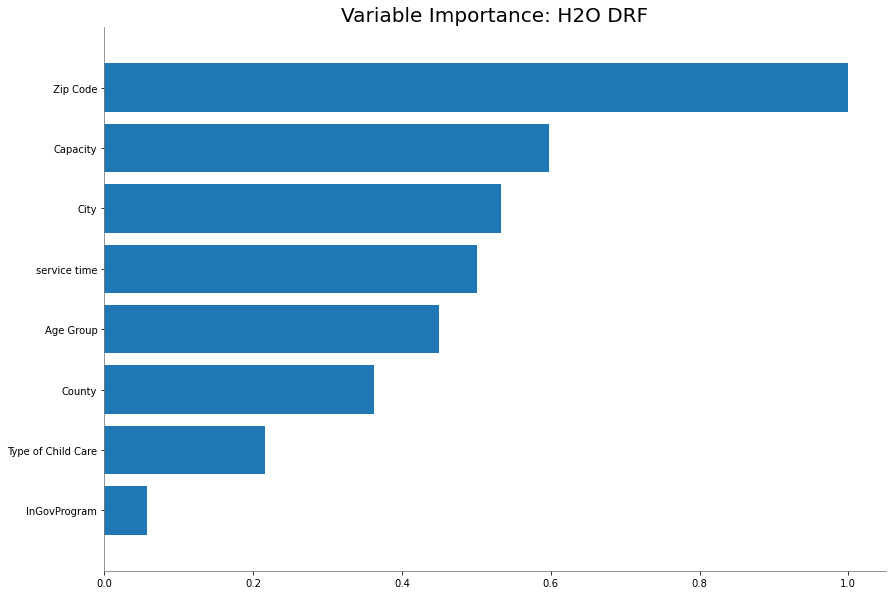

In [30]:
model.varimp_plot()

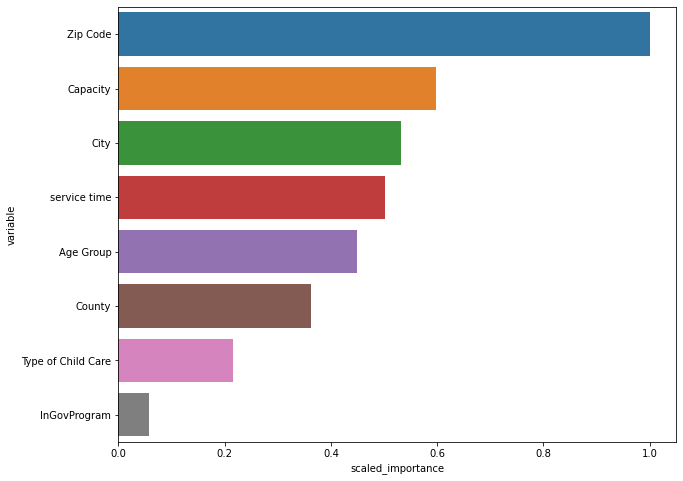

In [31]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [32]:
#check prediction performance
model.model_performance(test_data=test)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.309345447676773
RMSE: 0.5561883203347343
LogLoss: 1.6867187029128397
Mean Per-Class Error: 0.774931129476584
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,115.0,0.0,0.0,2.0,1.0,3.0,0.049587,6 / 121
1,6.0,0.0,0.0,0.0,0.0,0.0,1.000000,6 / 6
2,4.0,0.0,0.0,1.0,1.0,4.0,1.000000,10 / 10
3,14.0,0.0,1.0,0.0,1.0,4.0,1.000000,20 / 20
4,4.0,0.0,0.0,0.0,0.0,3.0,1.000000,7 / 7
5,18.0,0.0,1.0,2.0,0.0,14.0,0.600000,21 / 35
6,161.0,0.0,2.0,5.0,3.0,28.0,0.351759,70 / 199



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.648241
1,2,0.804020
2,3,0.874372
3,4,0.924623
4,5,0.979900
5,6,1.000000


In [33]:
#check target sample size of each category
df['Delaware STARS Level'].value_counts()

0    550
5    167
3     93
2     59
4     58
1     25
Name: Delaware STARS Level, dtype: int64

**Comments:** 
We get a model with very poor prefomace as we can see from the results using test set. **The Mean Per-Class Error is as 0.775** and the confusion matrix indicates a bad performance.

**Potential reason** is the limitation of sample size, especially for level 1, level 2, level 3, and level 4. The test set has error rate of 1 for those four. 

One **improvement idea** is to combine the four categories, so that we have level 0, level (1&2&3&4), level 5. 
By doing this, the sample size of each category seems to be balanced a little bit.

In [34]:
#create a new attribute named rank to combine level 1 to level 4

df.loc[(df['Delaware STARS Level']>0) & (df['Delaware STARS Level']<5),'Rank']=2
df.loc[(df['Delaware STARS Level']==0), 'Rank']=0
df.loc[(df['Delaware STARS Level']==5), 'Rank']=5


In [35]:
#check if we have done it correctly
df['Rank'].value_counts()

0.0    550
2.0    235
5.0    167
Name: Rank, dtype: int64

### Redo the random forest classification using Rank as the response variable

In [36]:
# Transform df to H2O Frame
h2o_df = H2OFrame(df)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [37]:
h2o_df['Zip Code'] = h2o_df['Zip Code'].asfactor()
h2o_df['Delaware STARS Level'] = h2o_df['Delaware STARS Level'].asfactor()
h2o_df['InGovProgram'] = h2o_df['InGovProgram'].asfactor()
h2o_df['Rank'] = h2o_df['Rank'].asfactor()

In [38]:
h2o_df.summary()

,County,Type of Child Care,City,Zip Code,Age Group,Capacity,Opening Time,Closing Time,Delaware STARS Level,service time,InGovProgram,Rank
type,enum,enum,enum,enum,enum,int,time,time,enum,real,enum,enum
mins,,,,,,5.0,1623558600000.0,1623542400000.0,,2.5,,
mean,,,,,,51.38760504201686,1623567563760.5022,1623606153466.387,,11.047093837535034,,
maxs,,,,,,585.0,1623607200000.0,1623627000000.0,,23.5,,
sigma,,,,,,64.18222917843241,4893017.379120079,8840531.87001737,,2.5455712771987526,,
zeros,,,,,,0,0,0,,0,,
missing,0,0,0,0,0,0,0,0,0,0,0,0
0,Sussex,Licensed Family Child Care,GEORGETOWN,19947,Infant through Pre-School,9.0,2021-06-13 07:30:00,2021-06-13 17:00:00,0,9.5,1,0
1,New Castle,Licensed Child Care Center,WILMINGTON,19801,Infant through Pre-School,99.0,2021-06-13 06:45:00,2021-06-13 18:00:00,5,11.25,1,5
2,New Castle,Licensed Family Child Care,WILMINGTON,19802,Infant through School-Age,9.0,2021-06-13 07:00:00,2021-06-13 17:00:00,0,10.0,1,0


In [39]:
# Split into training, valid, and test dataset
train, valid, test = h2o_df.split_frame([0.6, 0.2], seed=42)

feature = ['County', 'Type of Child Care', 'City', 'Zip Code', 'Age Group','Capacity','service time','InGovProgram']
target = 'Rank'

In [40]:

# Build random forest model2
model2 = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model2.train(x=feature, y=target, training_frame=train, validation_frame=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [41]:
model2

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1623622614850_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,300.0,510567.0,11.0,20.0,16.636667,64.0,158.0,108.59




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.14302707643649132
RMSE: 0.3781892071919707
LogLoss: 0.44968903338824684
Mean Per-Class Error: 0.1826781349829698
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,2,5,Error,Rate
0,277.0,36.0,14.0,0.152905,50 / 327
1,94.0,232.0,4.0,0.296970,98 / 330
2,24.0,8.0,294.0,0.098160,32 / 326
3,395.0,276.0,312.0,0.183113,180 / 983



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.816887
1,2,0.982706
2,3,1.000000



ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.294830937626497
RMSE: 0.5429833677254737
LogLoss: 1.0141456356648395
Mean Per-Class Error: 0.5144850733086027
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,2,5,Error,Rate
0,88.0,10.0,4.0,0.137255,14 / 102
1,19.0,11.0,4.0,0.676471,23 / 34
2,16.0,11.0,10.0,0.729730,27 / 37
3,123.0,32.0,18.0,0.369942,64 / 173



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.630058
1,2,0.867052
2,3,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-06-13 18:17:24,0.003 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-06-13 18:17:24,0.031 sec,1.0,0.492335,5.606667,0.268698,NaN,NaN,0.685314,14.533188,0.427746,NaN,NaN
2,,2021-06-13 18:17:24,0.042 sec,2.0,0.475449,4.564609,0.257732,NaN,NaN,0.581434,7.921631,0.369942,NaN,NaN
3,,2021-06-13 18:17:24,0.052 sec,3.0,0.466220,4.171681,0.256831,NaN,NaN,0.570087,5.875098,0.416185,NaN,NaN
4,,2021-06-13 18:17:24,0.063 sec,4.0,0.452895,3.624931,0.241212,NaN,NaN,0.556551,4.736951,0.410405,NaN,NaN
5,,2021-06-13 18:17:24,0.077 sec,5.0,0.441157,3.287413,0.229638,NaN,NaN,0.550691,3.806793,0.393064,NaN,NaN
6,,2021-06-13 18:17:24,0.091 sec,6.0,0.429461,2.750193,0.223799,NaN,NaN,0.547971,3.073473,0.381503,NaN,NaN
7,,2021-06-13 18:17:24,0.105 sec,7.0,0.422752,2.596438,0.227712,NaN,NaN,0.551593,3.091384,0.398844,NaN,NaN
8,,2021-06-13 18:17:24,0.117 sec,8.0,0.412335,2.198998,0.217895,NaN,NaN,0.548648,3.087831,0.387283,NaN,NaN
9,,2021-06-13 18:17:24,0.129 sec,9.0,0.408037,2.009226,0.207292,NaN,NaN,0.548329,2.908954,0.381503,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Zip Code,7994.471680,1.000000,0.227806
1,Capacity,7295.916992,0.912620,0.207900
2,service time,4606.187500,0.576172,0.131255
3,City,4525.141602,0.566034,0.128946
4,Type of Child Care,3867.222168,0.483737,0.110198
5,Age Group,3850.885986,0.481694,0.109733
6,County,2356.097168,0.294716,0.067138
7,InGovProgram,597.466980,0.074735,0.017025


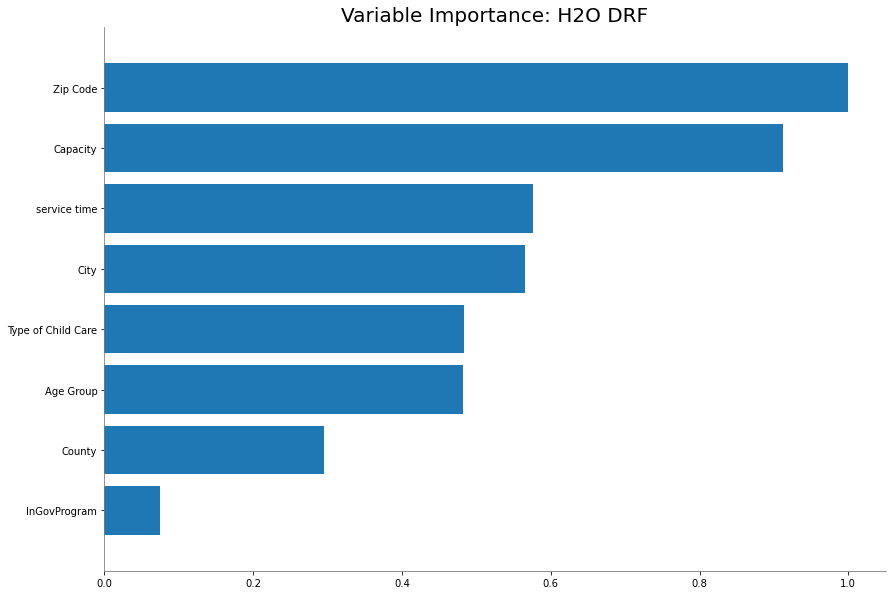

In [42]:
model2.varimp_plot()

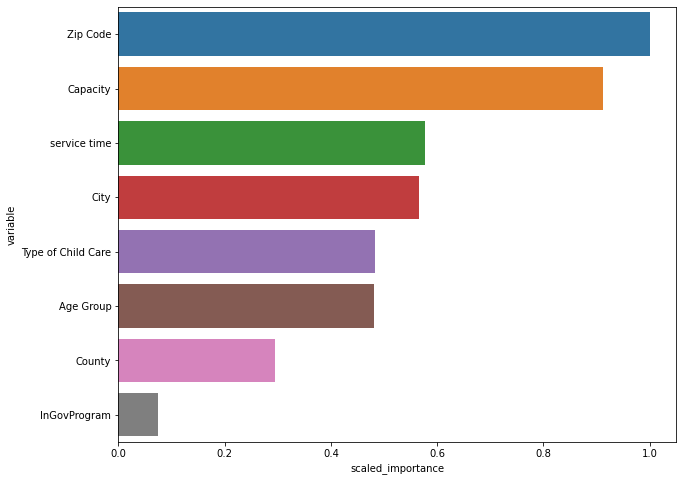

In [43]:
# Feature importance
importance = model2.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [44]:
model2.model_performance(test_data=test)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.2538895651074246
RMSE: 0.5038745529468864
LogLoss: 0.9681526912607485
Mean Per-Class Error: 0.5200040269807712
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,2,5,Error,Rate
0,110.0,7.0,4.0,0.090909,11 / 121
1,23.0,13.0,7.0,0.697674,30 / 43
2,14.0,13.0,8.0,0.771429,27 / 35
3,147.0,33.0,19.0,0.341709,68 / 199



Top-3 Hit Ratios: 


,k,hit_ratio
0,1,0.658291
1,2,0.919598
2,3,1.000000


**Comments:** 

We can see significant improvements of the second model while the overall performance is still not that good with a Mean Per-Class Error equal to 0.52. The confusion matrix improved while still not a good prediction.

**Potential reason** 
1. Still the sample size is relatively small for the second category (level 1 through level 4).

2. We did not consider the numerical meaning of the target variable as the level actually is an ordinal variable( e.g., level 5 is the best.)

**improvement idea**
1. For reason 1, common method we should consider is data resampling, especially in binary classification (e.g., removing samples from the majority class, or adding more examples from the minority class.) While in this case, we already set balance_classes=True in random forest modeling. Therefore, it may not actually work considering the sample size is too small in four categories. In the future, if more data is available, we can redo the classification to get better performance. 


2. For reason 2, we may try ordinal classification or econometric models like ordered probit model if more time is allowed.


# Some thoughts based on the model results

**Geographic factors** seem to be very important as both Zip code and City are important factors from the model output. From these, I assume that there might be an inequity issue in Delaware with regarding to child care service resources.
    
However, we should also recognize that this result can be **partially explained by the limitation of random forest**. As Zip code and City both have **many categories**, the random forest can be biased in favor of these variables. Therefore, some metrics are designed to evaluate it from different aspects.

### number of facilities per spatial unit

#### Zip Code

*I did a similar quick analysis to map the results of zip code to the map of Delaware using Q-GIS. Results can be seen from PDF file.*

In [45]:
#create a subset including all necessary variables
subset = data_s[['License Number','County','Type of Child Care','City','Zip Code','Age Group','Capacity','Opening Time','Closing Time','Delaware STARS Level','service time','InGovProgram']]

In [46]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 1003
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   License Number        952 non-null    int64         
 1   County                952 non-null    object        
 2   Type of Child Care    952 non-null    object        
 3   City                  952 non-null    object        
 4   Zip Code              952 non-null    int64         
 5   Age Group             952 non-null    object        
 6   Capacity              952 non-null    int64         
 7   Opening Time          952 non-null    datetime64[ns]
 8   Closing Time          952 non-null    datetime64[ns]
 9   Delaware STARS Level  952 non-null    int64         
 10  service time          952 non-null    float64       
 11  InGovProgram          952 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(4), object(4)
memory usage: 136.7+ KB

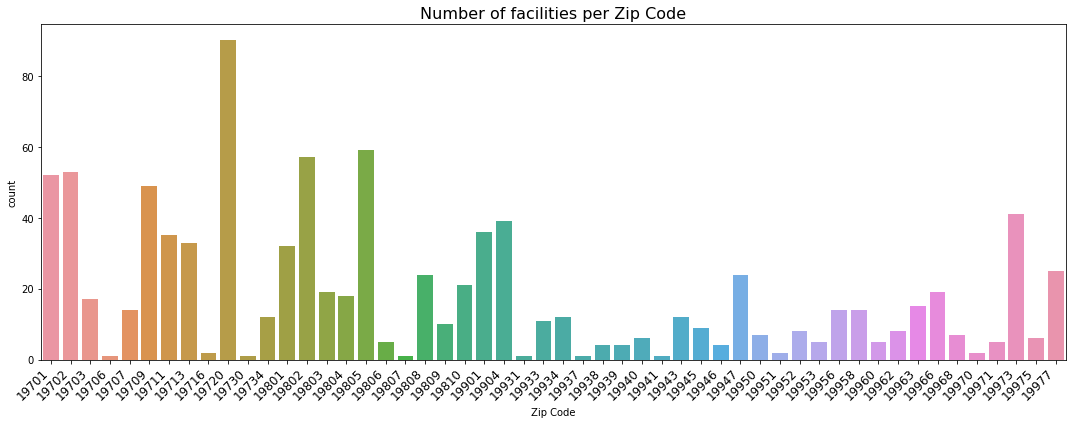

In [47]:
# Visualization of different zipcodes
grouped = subset[['Zip Code', 'License Number']].groupby('Zip Code').count().reset_index()
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x= 'Zip Code', data=subset, ax=ax)
ax.set_title('Number of facilities per Zip Code', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.tight_layout()
plt.show()

#### City

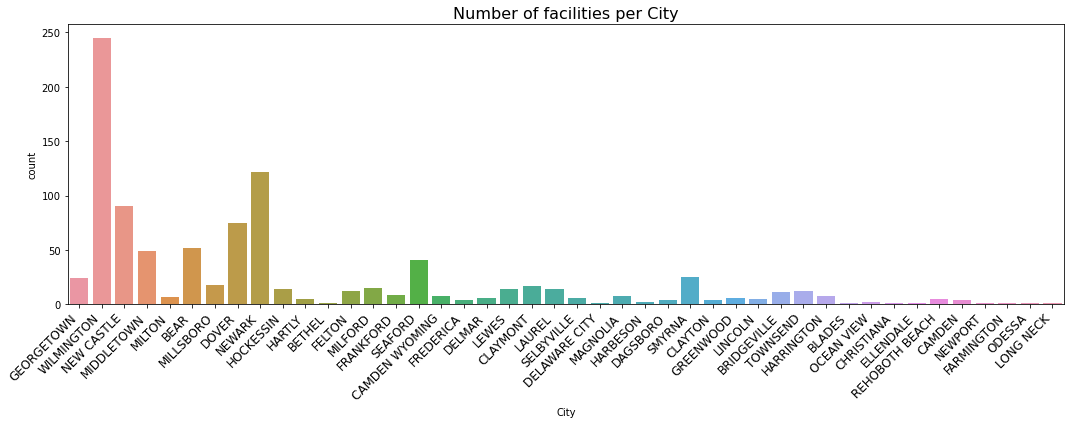

In [48]:
# Visualization of different cities
grouped = subset[['City', 'License Number']].groupby('City').count().reset_index()
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x= 'City', data=subset, ax=ax)
ax.set_title('Number of facilities per City', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.tight_layout()
plt.show()

### available service person * hours  per spatial unit

*As capacity and service time are also important factors, I decice to design a new metric to measure the total service person hours for each spatial unit.*

In [49]:
#create a column for personhours of each facility
subset['personhr'] = subset['Capacity'] * subset['service time']

#### Zip Code

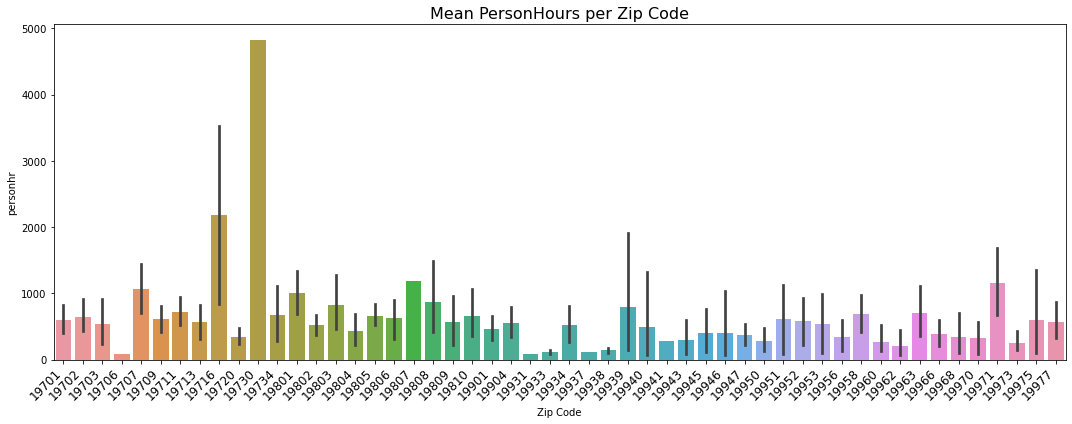

In [50]:
# Visualization of different zipcodes
grouped = subset[['personhr', 'Zip Code']].groupby('Zip Code').mean().reset_index()
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=subset['Zip Code'], y=subset['personhr'], ax=ax)
ax.set_title('Mean PersonHours per Zip Code', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.tight_layout()
plt.show()

#### City

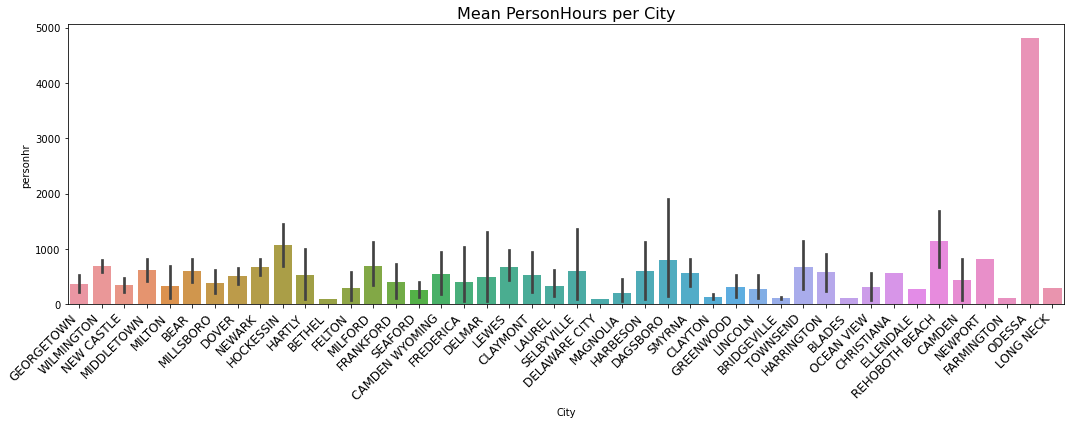

In [51]:
# Visualization of different cities
grouped = subset[['personhr', 'City']].groupby('City').mean().reset_index()
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=subset['City'], y=subset['personhr'], ax=ax)
ax.set_title('Mean PersonHours per City', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize = 12)
plt.tight_layout()
plt.show()

